generate radial tree/dendrogram for pathway-pathway scores, visualize relationship of secRecon ontology relative to GO-BP

expectation: secRecon terms will cluster with related, more general GO-BP terms

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
# import radialtree as rt
import omniplot as op # https://github.com/koonimaru/omniplot

/Users/jasminetat/opt/anaconda3/envs/pymde/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# import the data
import pickle

# save anndata pkl
with open('../data/allscreens_go-secrecon-scored.pkl','rb') as f:
    ad = pickle.load(f)

In [3]:
# read in secrecon genes
with open('/Users/jasminetat/Documents/projects/secRecon/JT_secRecon_github/secseq_plasma/data/gene_dict.pkl','rb') as f:
    gene_dict = pickle.load(f)
len([*gene_dict]),[*gene_dict][:5]

# import secrecon genesets
with open('/Users/jasminetat/Documents/projects/secRecon/JT_secRecon_github/secseq_plasma/data/t2g_dict.pickle','rb') as f:
    t2g_dict = pickle.load(f)

    
# import secRecon ontology mappings
with open('/Users/jasminetat/Documents/projects/secRecon/JT_secRecon_github/secseq_plasma/data/ont_c2p.pickle','rb') as f:
    ont_c2p = pickle.load(f)

with open('/Users/jasminetat/Documents/projects/secRecon/JT_secRecon_github/secseq_plasma/data/ont_c2p_2.pickle','rb') as f:
    ont_c2p_2 = pickle.load(f)

In [4]:
# subset for strong perturbations

# strong perturbation criteria
## at least 50 DEGs at sig p<0.05 by AD test following BH correction
## at least 30% target knockdown or was not detected
## at least 25 cells that passed quality filters

strong_thresh = {}
strong_thresh['anderson_darling_counts'] = 50 # no. DEGs identified by AD test at sig. BH-pval < 0.05
strong_thresh['num_cells_filtered'] = 25 # at least no. cells bearing genetic perturbation, after filtering to remove cells
strong_thresh['pct_expr'] = -0.3 # at least 30% target knockdown (negative value means decreased expr vs ctrl cells)

In [5]:
# filter for strong perturbations again
# subset each anndata for "strong" perturbation population ## about 1000-1500 perturbations

## k562 global: 2k strong perturbations; 14% secRecon coverage; 8% of perturbations

ad_strong = {}
for i in [*ad]:
    print(i)
    ad_strong[i] = ad[i][ad[i].obs.anderson_darling_counts >= strong_thresh['anderson_darling_counts'], :].copy()
    ad_strong[i] = ad_strong[i][ad_strong[i].obs.num_cells_filtered >= strong_thresh['num_cells_filtered'], :].copy()
    ad_strong[i] = ad_strong[i][ad_strong[i].obs.pct_expr <= strong_thresh['pct_expr'], :].copy()

    print('\t',ad_strong[i].shape)

k_g
	 (1946, 8248)
k_es
	 (1099, 8563)
rpe
	 (1591, 8749)


In [6]:
# k_g and all scores
data_all = ad_strong['k_g'].obs.copy()
data_all.index = data_all['gene_ind']
data_all = data_all[[c for c in data_all.columns if 'GO:' in c or 'SR_' in c]]
data_all

,GO:0002181_cytoplasmic.translation,GO:0002376_immune.system.process,GO:0003014_renal.system.process,GO:0003016_respiratory.system.process,GO:0006091_generation.of.precursor.metabolites.and.energy,GO:0006281_DNA.repair,GO:0006310_DNA.recombination,GO:0006351_DNA-templated.transcription,GO:0006355_regulation.of.DNA-templated.transcription,GO:0006486_protein.glycosylation,...,SR_Exosome/secreted,SR_Disulfide bond formation,SR_Membrane fusion,SR_Translocation,SR_Co-translational translocation,SR_Lysosomes,SR_Cytoskeletal remodeling,SR_Golgi organization,SR_Glycosphingolipid,SR_ATF6 pathway
gene_ind,,,,,,,,,,,,,,,,,,,,,
ZBTB5,0.130313,-0.027439,0.026477,-0.012129,0.005633,-0.012665,-0.024768,-0.006018,-0.000757,0.032896,...,-0.014804,0.217248,-0.001950,0.139021,0.151887,0.004207,-0.038902,0.033720,-0.011645,0.447754
ZBTB8OS,0.128382,0.029306,-0.067321,0.017824,-0.116237,0.007031,-0.009286,-0.013371,0.001544,-0.002829,...,-0.016423,0.036872,-0.024703,0.001284,0.005895,-0.013568,0.010387,0.052135,-0.009453,0.039445
ZC3H13,-0.265695,0.038178,0.003488,-0.061331,0.047204,-0.050499,-0.062129,-0.015111,-0.008072,0.012409,...,0.011989,0.135515,-0.018008,-0.005416,0.000357,0.049703,-0.145119,0.037379,-0.023850,0.057793
ZC3H18,-0.164116,-0.031223,-0.047422,-0.018475,-0.026484,-0.006450,-0.001456,0.045762,-0.004984,-0.008749,...,-0.040510,-0.010619,-0.032302,-0.000703,0.030193,-0.011705,-0.022684,0.060385,-0.027052,-0.059546
ZC3H3,-0.128194,0.046707,0.027736,-0.043797,-0.008837,0.000300,-0.047100,0.006168,0.018107,0.016828,...,-0.004388,0.076809,-0.012915,-0.025419,-0.005118,-0.050355,-0.055538,0.039492,-0.019226,-0.029317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZBTB17,-0.192344,0.000249,-0.031158,-0.086457,0.050645,-0.000602,0.006213,0.001024,0.006293,-0.029979,...,0.014989,-0.015354,0.017953,0.006951,0.010851,0.012438,0.055597,0.001275,0.005623,0.015276
C16orf87,-0.037304,-0.010369,0.002305,0.013566,0.045036,0.000457,-0.017847,0.010898,-0.004329,0.012994,...,0.000092,0.071059,0.019321,0.031222,0.053982,0.004218,0.028726,0.012171,0.023394,0.012147
ZBTB39,-0.079245,0.001056,-0.014882,0.058042,0.058807,-0.015565,-0.044076,-0.000570,-0.030335,0.007210,...,-0.004457,-0.055762,-0.006417,0.025872,0.068550,-0.003588,-0.045229,0.058851,-0.031612,0.015877


In [10]:
gs_list = data_all.T.index.tolist()
gs_list

['GO:0002181_cytoplasmic.translation',
 'GO:0002376_immune.system.process',
 'GO:0003014_renal.system.process',
 'GO:0003016_respiratory.system.process',
 'GO:0006091_generation.of.precursor.metabolites.and.energy',
 'GO:0006281_DNA.repair',
 'GO:0006310_DNA.recombination',
 'GO:0006351_DNA-templated.transcription',
 'GO:0006355_regulation.of.DNA-templated.transcription',
 'GO:0006486_protein.glycosylation',
 'GO:0006520_amino.acid.metabolic.process',
 'GO:0006629_lipid.metabolic.process',
 'GO:0006790_sulfur.compound.metabolic.process',
 'GO:0006913_nucleocytoplasmic.transport',
 'GO:0006914_autophagy',
 'GO:0006954_inflammatory.response',
 'GO:0007005_mitochondrion.organization',
 'GO:0007010_cytoskeleton.organization',
 'GO:0007031_peroxisome.organization',
 'GO:0007040_lysosome.organization',
 'GO:0007059_chromosome.segregation',
 'GO:0007163_establishment.or.maintenance.of.cell.polarity',
 'GO:0012501_programmed.cell.death',
 'GO:0016071_mRNA.metabolic.process',
 'GO:0022414_repro

In [11]:
gs_colors = {'db':['grey' if 'GO' in i else 'pink' for i in gs_list]}

In [12]:
from omniplot import plot as op

In [41]:
gs_list_mod = []
for i in gs_list:
# for i in testlist:

    if 'GO' in i.split('_')[0]:
#         print(i)
        db='GO'
        
        i_term = i.split('_')[1]
        
        i_term = i_term.replace('endoplasmic.reticulum','ER')
        i_term = i_term.replace('golgi','Golgi')
    
        if any(item in i_term for item in ['atf6','ire1','perk','atp','gpi']):
            i_term = i_term.replace('atf6','ATF6').replace('ire1','IRE1').replace('perk','PERK').replace('atp','ATP').replace('gpi','GPI')
            
#         i_temp = 
        i_mod = 'GO_'+i_term
    else:
        db='SR'
        
        # remove spaces
        i=i.replace(' ','.')
        i=i.replace('golgi','Golgi')
        i_mod = i
        
    gs_list_mod.append(i_mod)
    
gs_list_mod

['GO_cytoplasmic.translation',
 'GO_immune.system.process',
 'GO_renal.system.process',
 'GO_respiratory.system.process',
 'GO_generation.of.precursor.metabolites.and.energy',
 'GO_DNA.repair',
 'GO_DNA.recombination',
 'GO_DNA-templated.transcription',
 'GO_regulation.of.DNA-templated.transcription',
 'GO_protein.glycosylation',
 'GO_amino.acid.metabolic.process',
 'GO_lipid.metabolic.process',
 'GO_sulfur.compound.metabolic.process',
 'GO_nucleocytoplasmic.transport',
 'GO_autophagy',
 'GO_inflammatory.response',
 'GO_mitochondrion.organization',
 'GO_cytoskeleton.organization',
 'GO_peroxisome.organization',
 'GO_lysosome.organization',
 'GO_chromosome.segregation',
 'GO_establishment.or.maintenance.of.cell.polarity',
 'GO_programmed.cell.death',
 'GO_mRNA.metabolic.process',
 'GO_reproductive.process',
 'GO_signaling',
 'GO_protein.catabolic.process',
 'GO_regulatory.ncRNA-mediated.gene.silencing',
 'GO_ribosome.biogenesis',
 'GO_cilium.organization',
 'GO_cell.motility',
 'GO_nerv

In [47]:
vizdf = data_all.T.copy()
vizdf.index = gs_list_mod
vizdf_genecols = vizdf.columns.tolist()
vizdf['db'] = [i.split('_')[0] for i in vizdf.index.tolist()]
vizdf

gene_ind,ZBTB5,ZBTB8OS,ZC3H13,ZC3H18,ZC3H3,ZC3H4,ZCCHC8,ZCCHC9,ZCRB1,ZDHHC7,...,YEATS4,YME1L1,C16orf72,ZBTB14,ZBTB17,C16orf87,ZBTB39,ZBTB44,AAR2,db
GO_cytoplasmic.translation,0.130313,0.128382,-0.265695,-0.164116,-0.128194,-0.246867,0.071651,-0.887367,0.198205,-0.546108,...,0.224346,0.018134,0.157674,0.308792,-0.192344,-0.037304,-0.079245,-0.069601,-0.757060,GO
GO_immune.system.process,-0.027439,0.029306,0.038178,-0.031223,0.046707,0.045708,0.027124,0.001324,-0.046426,0.188738,...,0.016807,0.058891,0.018767,-0.017843,0.000249,-0.010369,0.001056,-0.005792,0.001494,GO
GO_renal.system.process,0.026477,-0.067321,0.003488,-0.047422,0.027736,-0.013574,0.034445,-0.056938,0.001852,0.009574,...,0.008851,-0.014528,0.075681,-0.114963,-0.031158,0.002305,-0.014882,0.019574,0.018649,GO
GO_respiratory.system.process,-0.012129,0.017824,-0.061331,-0.018475,-0.043797,-0.009365,-0.048302,0.023371,-0.003399,0.036208,...,-0.015388,0.071776,-0.009611,0.119550,-0.086457,0.013566,0.058042,0.009734,0.099488,GO
GO_generation.of.precursor.metabolites.and.energy,0.005633,-0.116237,0.047204,-0.026484,-0.008837,0.042068,-0.026016,0.039618,0.054639,0.057440,...,-0.025967,-0.058296,0.029284,0.071372,0.050645,0.045036,0.058807,0.017999,0.014429,GO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SR_Lysosomes,0.004207,-0.013568,0.049703,-0.011705,-0.050355,0.023153,-0.015726,0.023929,-0.000829,-0.017563,...,-0.040566,-0.005709,-0.014109,-0.006651,0.012438,0.004218,-0.003588,-0.013712,0.021401,SR
SR_Cytoskeletal.remodeling,-0.038902,0.010387,-0.145119,-0.022684,-0.055538,-0.037389,-0.026969,0.084577,-0.075122,-0.039555,...,-0.010562,-0.001351,-0.011779,-0.217126,0.055597,0.028726,-0.045229,0.048578,0.089714,SR
SR_Golgi.organization,0.033720,0.052135,0.037379,0.060385,0.039492,-0.068457,0.037866,-0.117464,0.036457,-0.069763,...,-0.032152,0.007642,0.024668,0.093566,0.001275,0.012171,0.058851,-0.004400,0.027243,SR
SR_Glycosphingolipid,-0.011645,-0.009453,-0.023850,-0.027052,-0.019226,-0.033177,0.016384,-0.121648,-0.033485,0.042138,...,-0.021434,-0.009234,-0.014104,-0.124200,0.005623,0.023394,-0.031612,-0.004431,-0.056222,SR


In [64]:
%config InlineBackend.print_figure_kwargs = {'facecolor': 'white'}


/Users/jasminetat/opt/anaconda3/envs/pymde/lib/python3.11/site-packages/omniplot/plot.py:106: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method=tree_method)


179 179


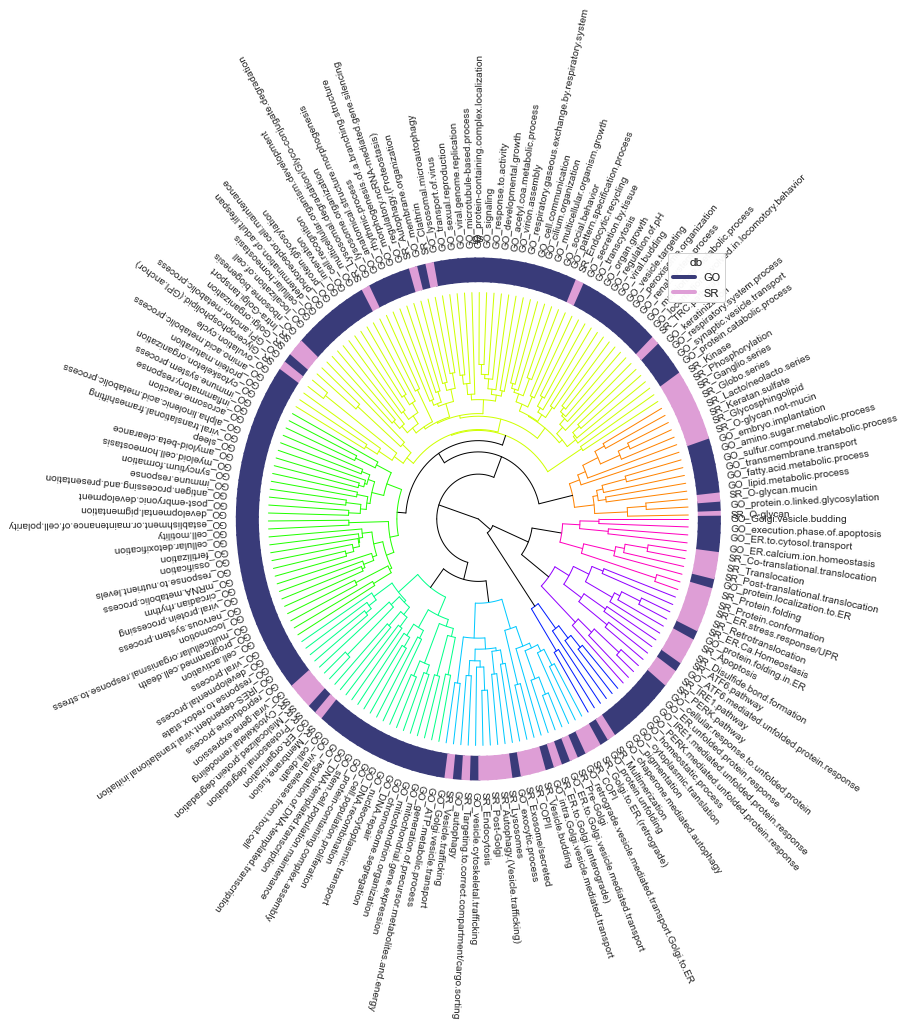

In [81]:
# op.radialtree(i_dend,fontsize=8,figsize=[10,10],addlabels=True, show=True,sample_classes=None,colorlabels=gs_colors)
# plt.figure(facecolor='white')
# plt.figure(figsize=[15, 15])

rt = op.radialtree(
    vizdf,
    n_clusters=8,
    variables=vizdf_genecols,
    category='db',
    distance_method="correlation",
    tree_method="average",
    title= "gs",
    linewidth= 1,
    figsize= [10,10], #colorlabels=gs_colors,
    fontsize=10,colorlabels_legend=None
)
plt.savefig("perturbseq_dend.svg",format="svg",bbox_inches='tight')

# plt.rcParams['figure.facecolor'] = 'white'  # Sets figure background to white
# plt.rcParams['axes.facecolor'] = 'white'